In [32]:
import pandas as pd
from math import sqrt
import numpy as np
from itertools import chain
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from numpy import concatenate
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

In [33]:
def timeseries_to_supervised(df, n_in, n_out):
  agg = pd.DataFrame()
  for i in range(n_in, 0, -1):
    df_shifted = df.shift(i).copy()
    df_shifted.rename(columns=lambda x: ('%s(t-%d)' % (x, i)), inplace=True)
    agg = pd.concat([agg, df_shifted], axis=1)
  for i in range(0, n_out):
    df_shifted = df.shift(-i).copy()
    if i == 0:
      df_shifted.rename(columns=lambda x: ('%s(t)' % (x)), inplace=True)
    else:
      df_shifted.rename(columns=lambda x: ('%s(t+%d)' % (x, i)), inplace=True)
    agg = pd.concat([agg, df_shifted], axis=1)
  agg.dropna(inplace=True)
  return agg

In [34]:
X = pd.read_excel('data_akbilgic(1).xlsx',usecols = "B:I")  # loading the data

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(X)

# convert ndarray to pandas dataframe
scaled = pd.DataFrame(scaled, columns=["data.1", "data.2", "data.3", "data.4", "data.5", "data.6", "data.7", "data.8"])

n_steps = 6
sdf = timeseries_to_supervised(scaled, n_steps, 1)
lst = []
for i in range(1,8):
  lst.append((n_steps+1)*8 - i)
# removing the columns we do not need (SP(t), DAX(t), FTSE(t), NIKKEI(t), BOVESPA(t), EU(t), EM(t))
sdf.drop(sdf.columns[lst], axis=1, inplace=True)
print(sdf)
#sdf.to_excel("test.xlsx")

     data.1(t-6)  data.2(t-6)  data.3(t-6)  ...  data.7(t-1)  data.8(t-1)  data.1(t)
6       0.664154     0.404333     0.489969  ...     0.313877     0.184496   0.455624
7       0.628741     0.505990     0.546240  ...     0.315871     0.390618   0.265266
8       0.314902     0.194024     0.310007  ...     0.031043     0.346048   0.363922
9       0.000000     0.470147     0.364884  ...     0.317164     0.175245   0.631251
10      0.509203     0.266894     0.291678  ...     0.495236     0.572906   0.217804
..           ...          ...          ...  ...          ...          ...        ...
525     0.409163     0.504739     0.438167  ...     0.492265     0.407771   0.494245
526     0.647323     0.577499     0.604836  ...     0.455700     0.394418   0.439530
527     0.533918     0.420259     0.469508  ...     0.395244     0.281535   0.322631
528     0.306824     0.461667     0.482772  ...     0.389044     0.275618   0.491722
529     0.532410     0.465978     0.498359  ...     0.462147     

In [35]:
sdf = sdf.values

# Split data into train and test
len_data = sdf.shape[0]
print("Total length of data:", len_data)
train_size = int(len_data * .7)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len_data - train_size))

train = sdf[:train_size, :]
test = sdf[train_size:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


Total length of data: 524
Train size: 366
Test size: 158
(366, 1, 48) (366,) (158, 1, 48) (158,)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1, 300)            14700     
_________________________________________________________________
dense_10 (Dense)             (None, 1, 100)            30100     
_________________________________________________________________
dense_11 (Dense)             (None, 1, 1)              101       
Total params: 44,901
Trainable params: 44,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
366/366 - 1s - loss: 0.0280
Epoch 2/50
366/366 - 0s - loss: 0.0187
Epoch 3/50
366/366 - 0s - loss: 0.0150
Epoch 4/50
366/366 - 0s - loss: 0.0161
Epoch 5/50
366/366 - 0s - loss: 0.0155
Epoch 6/50
366/366 - 0s - loss: 0.0145
Epoch 7/50
366/366 - 0s - loss: 0.0160
Epoch 8/50
366/366 - 0s - loss: 0.0136
Epoch 9/50
366/366 - 0s - loss: 0.0131
Epoch 10/50
366/366 - 0s - lo

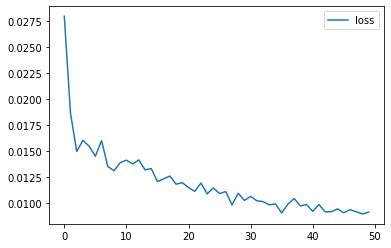

In [36]:
# Building a model with MLP
batch_size = 1 #1
model = Sequential()

model.add(Dense(units=300, input_shape=(train_X.shape[1], train_X.shape[2]), activation="relu"))
model.add(Dense(100, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

history = model.fit(train_X, train_y, epochs=50, batch_size=batch_size, verbose=2)

# plot history
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

In [37]:
# make a prediction
testPredict = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for prediction
testPredict = np.reshape(testPredict, (testPredict.shape[0], 1))
inv_testPredict = concatenate((testPredict, test_X[:, -7:]), axis=1)
inv_testPredict = scaler.inverse_transform(inv_testPredict)
inv_testPredict = inv_testPredict[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
test_y = concatenate((test_y, test_X[:, -7:]), axis=1)
test_y = scaler.inverse_transform(test_y)
test_y = test_y[:,0]

# calculate error
print("Test MSE: ", mean_squared_error(test_y, inv_testPredict))
print("Test MAE: ", sum(abs(test_y-inv_testPredict))/test_y.shape[0])
print("Test R2: ", r2_score(test_y, inv_testPredict))

trainPredict = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

# invert scaling for prediction
trainPredict = np.reshape(trainPredict, (trainPredict.shape[0], 1))
inv_trainPredict = concatenate((trainPredict, train_X[:, -7:]), axis=1)
inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
inv_trainPredict = inv_trainPredict[:,0]

# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
train_y = concatenate((train_y, train_X[:, -7:]), axis=1)
train_y = scaler.inverse_transform(train_y)
train_y = train_y[:,0]

Test MSE:  0.0002291309216534686
Test MAE:  0.011603969797428953
Test R2:  0.032296151473321766


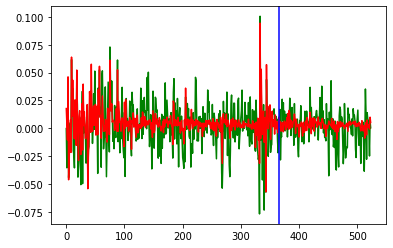

In [38]:
# Finally, we check the result in a plot. 
# A vertical line in a plot identifies a splitting point between 
# the training and the test part.
predicted = np.concatenate((inv_trainPredict,inv_testPredict),axis=0)

original = np.concatenate((train_y,test_y),axis=0)
predicted = np.concatenate((inv_trainPredict,inv_testPredict),axis=0)
index = range(0, original.shape[0])
plt.plot(index,original, 'g')
plt.plot(index,predicted, 'r')
plt.axvline(scaled.index[train_size], c="b")
plt.show()